<a href="https://colab.research.google.com/github/KevinFallon/fastai/blob/main/FastAi_Lesson5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"kfallon","key":"3dc1d3068976b9841082bb1cec0828ae"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os
from pathlib import Path

path = Path('titanic')
if not path.exists():
  import zipfile, kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 17.8MB/s]

In [4]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [5]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df.isna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
print(df.isna().sum())
print()
# you can't multiply coefficients with missing values. easiest way to fill in
# missing values is by using the mode.
modes = df.mode().iloc[0]
print(modes)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object


In [8]:
# usually filling in missing values with the mode doesn't make a significant difference
# on the outcomes. Especially when we're creating a first attempt at a model, we
# want to optimize for getting something working to start building our intuition.
# mode is easy and works most of the time, hence we use it.
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
# describe is useful to get a quick picture as to what the data looks like.
# describe all of the numeric variables
df.describe(include=np.number)

'''
in the output we can see interresting things like survived is only a 0 or 1.
this is seen in the values of the various percentiles. Pclass appears to only be 1, 2,3

fare is interesting because the max is significantly larger than 75%. probably
long tailed.
'''

'\nin the output we can see interresting things like survived is only a 0 or 1.\nthis is seen in the values of the various percentiles. Pclass appears to only be 1, 2,3\n\nfare is interesting because the max is significantly larger than 75%. probably\nlong tailed.\n'

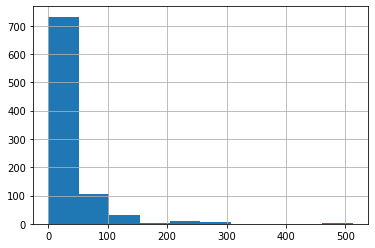

In [10]:
'''
long-tailed distribution- small # of really big values, lots of small ones.
certain types of models don't like long tailed distributions - e.g. linear models.
neural nets generally behave better without them too.
usually we take the log to normalize long tailed dists.

log(0) is NaN so useful trick is to take log(X+1)

usually things that grow exponentially like money or population, we want to take
the log of.
'''
df['Fare'].hist()

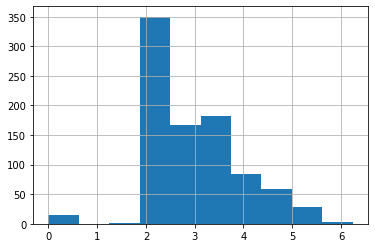

In [11]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist()

In [12]:
'''
as mentioned above, pclasses looks categorical, lets double check using the
unique function provided by pandas...
'''
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
# describe all the non numeric variables.
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [38]:
# added_cols = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
# head() gets the first 5 rows by default.
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [39]:
from torch import tensor

t_dep = tensor(df.Survived)
t_dep

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [40]:
# Ignore name, cabin, and ticket for now since there are many unique values.
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
# make sure they're all the same datatype (floats). pytorch wants things to be
# the same type if you're going to multiply things together.
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [41]:
t_indep.shape

#len of shape is called its rank - number of dimensions it has
len(t_indep.shape)

2

In [42]:
# so we can reproduce the results and maintain sanity for debugging.
# usually we dont want to do this in practice so we can see how our model
# performs with various initialized parameters. helps gain intuitive
# understanding
torch.manual_seed(442)

# we want 12 coeffs. [1] is the number of columns
n_coeff = t_indep.shape[1]

# have pytroch give us random num between 0 and 1. subtracting 1/2 makes them
# centered around 0.
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [43]:
# multiplies matrix by a vector!. uses broadcasting
print(t_indep.shape)
print(coeffs.shape)
# called broadcasting because its as if the vector of coeffs was copied 891
# times to match t_indep. As long as the last axes match, broadcasting should work

# vector times scalar - again different ranks and most simple example.
print(tensor([1., 2, 3]) * tensor(2.))

# a single line of code like this can run very quickly due to optimized C code
# underneath which allows us to have high performance in python 
t_indep*coeffs

torch.Size([891, 12])
torch.Size([12])
tensor([2., 4., 6.])


tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [44]:
'''
notice above that the age column has very high values relative to all other
columns which means that the sum will skew towards that value. we like to have
each column have the same range of values so that the optimization process
works correctly. if we divide each age by the max age, we'll have a range of
values between 0 and 1.
'''
vals, indices = t_indep.max(dim=0) # get the max of each row.
t_indep = t_indep / vals # works again thanks to broadcasting.

In [45]:
preds = (t_indep*coeffs).sum(axis=1) # sum up all of the columns

In [46]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [47]:
'''
now we have predictions but we need to use gradient descent to try and make these
better. to do gradient descent, we need a loss. the loss is a measure is how
good or bad these coefficients are.
'''
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [30]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

In [48]:
# _ at the end means in place.
# requires_grad tells pytorch what we want derivatives for. here we tell it we
# want derivatives for the coefficients.
# flips requires_grad=True in the tensor as shown in output.
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [52]:
loss = calc_loss(coeffs, t_indep, t_dep)
# now we'll see that pytorch is storing a gradient function.
# (loss is same as above still.)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [50]:
loss.backward()

In [53]:
# looking at output, take the first entry -0.0106 as an example which maps to age.
# output says if we increased age coefficient, loss would go down.
# negative means increasing would decrease the loss.
coeffs.grad


tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [55]:
# notice after this, the loss has decreased. 
with torch.no_grad():
  # 
  coeffs.sub_(coeffs.grad *0.01)
  print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5362)


In [56]:
from fastai.data.transforms import RandomSplitter

trn_split,val_split = RandomSplitter(seed=42)(df)

In [57]:
# list of the rows that will be in the validation set. need to use these values
# as indexes for the data.
val_split

(#178) [303,778,531,385,134,476,691,443,386,128...]

In [58]:
trn_indep,val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(713, 178)

In [60]:
def update_coeffs(coeffs, lr): coeffs.sub_(coeffs.grad * lr)

In [61]:
def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, trn_indep, trn_dep)
  loss.backward()
  with torch.no_grad(): update_coeffs(coeffs, lr)
  print(f"{loss:.3f}", end="; ")

In [62]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [63]:
def train_model(epochs=30, lr=0.01):
  torch.manual_seed(442)
  coeffs = init_coeffs()
  for i in range(epochs): one_epoch(coeffs, lr=lr)
  return coeffs

In [64]:
coeffs = train_model(18, lr=0.02)

0.536; 0.532; 0.525; 0.515; 0.503; 0.489; 0.477; 0.466; 0.449; 0.424; 0.396; 0.373; 0.354; 0.338; 0.321; 0.306; 0.297; 0.295; 

In [65]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
# eyeball the output. we see that older people had less chance of surviving and
# males had less chance of surviving. both of those make sense.
show_coeffs()

{'Age': tensor(-0.2335),
 'SibSp': tensor(0.1025),
 'Parch': tensor(0.2530),
 'LogFare': tensor(0.1073),
 'Sex_male': tensor(-0.4166),
 'Sex_female': tensor(0.3314),
 'Pclass_1': tensor(0.8639),
 'Pclass_2': tensor(0.4225),
 'Pclass_3': tensor(0.2875),
 'Embarked_C': tensor(0.1840),
 'Embarked_Q': tensor(0.3267),
 'Embarked_S': tensor(0.1158)}

In [66]:
preds = calc_preds(coeffs, val_indep)

In [68]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [69]:
results.float().mean()

tensor(0.7921)

In [70]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

In [71]:
preds[:28]

tensor([ 1.0550,  0.1648,  0.0210,  0.1432,  0.0940,  0.0883,  0.8792,  0.8332,  0.1986,  0.8419, -0.0691,  0.0877,  0.0729,  0.9130,
        -0.0780,  0.4887,  0.4303,  0.8954,  0.0644,  0.6831, -0.0458,  0.4566,  1.4014,  0.8986, -0.0359,  0.1958,  0.8296,  0.4391])

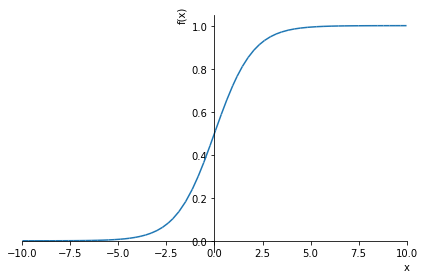

In [72]:
import sympy
# as my numbers get above 4,5 the asymptote to 1
# as numbers get below -4, or -5, the asymptote to 0
# this is what we want, so that all our values end up within the same range of
# 0 to 1. 
sympy.plot("1/(1+exp(-x))", xlim=(-10,10))


In [73]:
# we can now redefine calc_preds in this notebook and when we call train_model,
# it will use our updated version of calc_preds. highlights how useful notebooks
# are for experimenting

# when we have a binary dependent variable, we'll almost always throw it through
# a sigmoid.
def calc_preds(coeffs, indeps): return torch.sigmoid( (indeps*coeffs).sum(axis=1))


In [74]:
coeffs = train_model(lr=2)

0.510; 0.468; 0.397; 0.340; 0.309; 0.289; 0.268; 0.247; 0.230; 0.218; 0.210; 0.207; 0.205; 0.204; 0.204; 0.204; 0.204; 0.205; 0.205; 0.205; 0.205; 0.205; 0.205; 0.204; 0.203; 0.202; 0.201; 0.200; 0.198; 0.197; 

In [75]:
# accuracy has improved.
acc(coeffs)

tensor(0.8258)

In [76]:
show_coeffs()

{'Age': tensor(-1.6562),
 'SibSp': tensor(-1.1978),
 'Parch': tensor(-0.0264),
 'LogFare': tensor(2.0475),
 'Sex_male': tensor(-18.9596),
 'Sex_female': tensor(16.6258),
 'Pclass_1': tensor(7.8170),
 'Pclass_2': tensor(4.0900),
 'Pclass_3': tensor(-12.5817),
 'Embarked_C': tensor(3.1918),
 'Embarked_Q': tensor(1.0449),
 'Embarked_S': tensor(-5.8589)}